This Jupyter notebook, which is based on Python 3, is designed to calculate the abundances of N elements in the neutron star merger mixture. The notebook will contain several functions to easily calculate values such as temperature, abundances, and ionization potentials.

In this notebook, I have a function for the potentials, initialization of values, calculation of abundances, and plotting

In [1]:
#Importing Libraries
import saha_mult #Class used to calculate abundances 
import saha
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import scipy.constants as sc
from time import process_time #Useful for finding calculation times

import importlib 
importlib.reload(saha_mult) #This command ensures that any changes made to saha_mult class are reflected in this notebook

<module 'saha_mult' from '/home/nalamwar/Research/R-process_Mergers/Abundance_Calculations/saha_mult.py'>

In [2]:
#Read in data for ionization potentials and skynet stuff
#Note that the NIST data table includes many elements that just skip ionization potentials, so I set a cutoff at Lr.
nist = pd.read_excel("NIST Data Table.xlsx")
hf = h5py.File("SkyNet_r-process.h5")

In [3]:
#This function here will return all the ionization potentials of the desired elements. Enter the starting element and
#ending element Z number. This will return an array of arrays. Note the starting position of the array!

#The way I did this was similar to the Multiple Elements Scenario code, but I added an extra array called 
#returned_potentials, which is designed to return an array of all the desired potentials we wanted
ion_energies1d =  nist[' Ionization  Energy (eV)']

def ionization_generator(elements):
    max_el = 103 #This is defined to be the Z of the last element that I want in the list 
    ion_energies = list()
    returned_potentials = list()
    counter = 0

    for i in range(0,max_el+1):
        specific_list = list()

        for j in range(i):

            if isinstance(ion_energies1d[counter],str):

                if len(ion_energies1d[counter]) ==3:
                    specific_list.append(0)
                    counter+=1
                else:
                    str_num = '' 

                    for k in ion_energies1d[counter]:

                        if (k != ' ') and (k !='[') and (k !=']') and (k !='(') and (k !=')'):
                            str_num+=k

                    specific_list.append(np.abs(float(str_num)))
                    counter+=1


            else:
                specific_list.append(np.array((np.abs(ion_energies1d[counter]))))
                counter+=1

        ion_energies.append(specific_list)
    ion_energies[-1][-2] = np.average([ion_energies[-1][-1],ion_energies[-1][-3]])
        
    for i in range(len(elements)):
        returned_potentials.append(np.array((ion_energies[elements[i]])))        
        
    return np.array(returned_potentials)

In [4]:
#This cell is simply for temperature, and since it does not change no matter the elements used, I do not use a function
#At some point, I will have to find a way to find the places to calculate the indices to use to find slope for other hdf5s
temperature = hf["Temperature"]
time = hf["Time"]
mod_temp = []
full_temp = []

linear = np.polyfit(np.log10(np.array(time[900:1700])),np.log10(np.array(temperature[900:1700])),1)
m = linear[0]

for i in range(0,len(temperature)):
    if i < 1700:
        mod_temp.append(np.log10(temperature[i]))
        full_temp.append(temperature[i])
    else:
        del_t = m*(np.log10(time[i]) - np.log10(time[i-1]))
        mod_temp.append(mod_temp[i-1]+del_t)
        full_temp.append(10**mod_temp[i])

In [5]:
#initialization of ionization potentials and full abundances from Skynet
#used in the abundance calculation function
abundance = hf["Y"]
charge = hf["Z"]
density = hf["Density"]
kbEvpGK = 8.617e-5*1e9

def initialization(elements):

    full_abundance = []
    ion_potential = ionization_generator(elements)
    
    for i in range(len(elements)):
        temp_index = []
        temp_abundance = []
        
        for j in range(len(charge)):
            
            if charge[j] == (elements[i]): ##charge of element
                temp_index.append(j)
                
        temp_abundance = np.sum(abundance[:, temp_index], 1)
        full_abundance.append(temp_abundance)
        
    return np.array(full_abundance),np.array(ion_potential)

In [6]:
#Abundance function
def abundance_calculation(elements):
    x,y = initialization(elements)
    return (saha_mult.GetAbundances(x,np.array(full_temp),np.array(density),y))

In [7]:
#Call to function to generate data. Also, calculate time it takes.

time_start = process_time()
YI = abundance_calculation([8,9])
time_elapsed = (process_time() - time_start)
print("This calculation took",time_elapsed,' sec')

/home/nalamwar/Research/R-process_Mergers/Abundance_Calculations/saha_mult.py:109: RuntimeWarning: divide by zero encountered in log
  fLow = np.log(GetYefContribution(Ytot, T9, rho, lnYefLow, xi)) - lnYefLow
/home/nalamwar/Research/R-process_Mergers/Abundance_Calculations/saha_mult.py:110: RuntimeWarning: divide by zero encountered in log
  fHi = np.log(GetYefContribution(Ytot, T9, rho, lnYefHi, xi)) - lnYefHi
/home/nalamwar/Research/R-process_Mergers/Abundance_Calculations/saha_mult.py:121: RuntimeWarning: divide by zero encountered in log
  fMid = np.log(GetYefContribution(Ytot, T9, rho, lnYefMid, xi)) - lnYefMid


This calculation took 13.678712517  sec


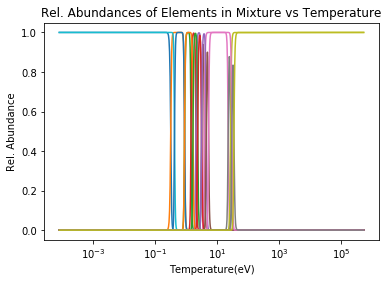

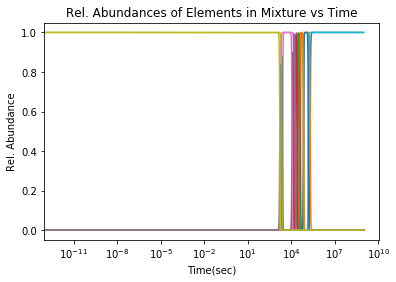

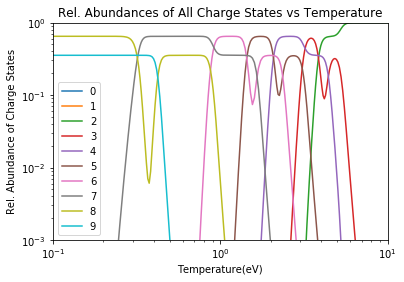

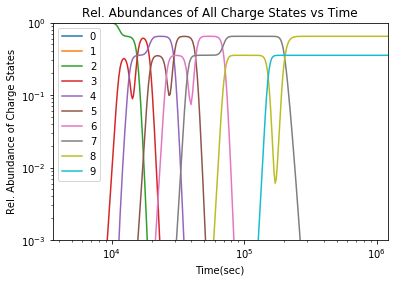

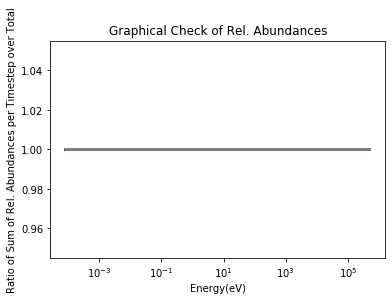

This calculation took 6.573592359999999  sec to graph


In [16]:
#Function to plot the abundances, the sum of all ionization states, and the graphical check
#At some point, I might add functionality to choosing which things to graph

#1 hr = 3600 sec
#2 Weeks = 1.21e+6 seconds

#Relative Abundances
def plotter(abun):
    
    time_start = process_time()
    #colors = ['r','b'] #Just a color scheme to indicate varying elements instead of having too many colors.
    x = np.zeros((len(abun[0]),len(abun[-1][0]))) #Initializing the array useful in tracking ionization state abundances
    checksum = []#Another way to calculating the total sum across time. 
    index_total = [] #Calculating total sum across time 
       
    #Plotting abundances vs Temp
    for Y in abun:
        Ytot = np.sum(Y,1)
        for i in range(len(Y[0])):
            plt.semilogx(kbEvpGK*np.array(full_temp),(Y[:,i])/Ytot,)
            plt.xlabel("Temperature(eV)")
            plt.ylabel("Rel. Abundance")
            plt.title("Rel. Abundances of Elements in Mixture vs Temperature")
    
    plt.show()
    
    
    #Plotting abundances vs Time
    for Y in abun:
        Ytot = np.sum(Y,1)
        for i in range(len(Y[0])):
            plt.semilogx(time,(Y[:,i])/Ytot,)
            plt.xlabel("Time(sec)")
            plt.ylabel("Rel. Abundance")
            plt.title("Rel. Abundances of Elements in Mixture vs Time")
    
    plt.show()
    
    
    #PLot of all Rel. Charge State Abundances over Temperature
    #So this sums up the abundances of everything with the same number of electrons.
    for Y in abun:
        x[0:len(Y),0:len(Y[0])]+=Y[:,-1::-1]
    
    for i in range(len(abun[-1][0])):
        Ytot = np.sum(x,1)
        plt.loglog(kbEvpGK*np.array(full_temp),x[:,i]/Ytot,label = i)
        plt.legend()
        plt.xlabel("Temperature(eV)")
        plt.ylabel("Rel. Abundance of Charge States")
        plt.title("Rel. Abundances of All Charge States vs Temperature")
        plt.xlim([0.1,10])
        plt.ylim([1.e-3, 1])
        
        
    plt.show()
    
    #Time vs Total Rel.Charge State Abundances

    for i in range(len(abun[-1][0])):
        Ytot = np.sum(x,1)
        plt.loglog(time,x[:,i]/Ytot,label = i)
        plt.legend()
        plt.xlabel("Time(sec)")
        plt.ylabel("Rel. Abundance of Charge States")
        plt.title("Rel. Abundances of All Charge States vs Time")
        plt.xlim([3600,1.21e+6]) #Specific range for 1 hr to 2 weeks of time in sec
        plt.ylim([1.e-3, 1])
        
    plt.show()
    
    
    #Plotting the Graphical Check
    for i in range(len(abun[0])):
        summation = 0
        temp_sum = 0
        for Y in abun:
            summation+=np.sum(Y[i])
            temp_sum+=np.sum(Y,1)
        checksum.append(summation)
        index_total.append(temp_sum)
    
    plt.semilogx(kbEvpGK*np.array(full_temp),np.array(checksum)/np.array(index_total))
    plt.xlabel("Energy(eV)")
    plt.ylabel("Ratio of Sum of Rel. Abundances per Timestep over Total")
    plt.title("Graphical Check of Rel. Abundances")
    plt.show()
    
    
    #Quick calculation of how long it takes
    time_elapsed = (process_time() - time_start)
    print("This calculation took",time_elapsed,' sec to graph')
    
plotter(YI)

In [17]:
#This is the calculation to make the time plot. Currently, it is commented out for convenience
'''times = []
elements = np.arange(1,80,1)

for i in elements:
    time_start = process_time()
    YI = abundance_calculation([i])
    times.append(process_time() - time_start)
    
plt.plot(elements,times)
plt.xlabel('Element Number')
plt.ylabel('Times(sec)')
plt.title('Calculation Times for Abundances')
plt.grid()
plt.savefig('times.png')'''

"times = []\nelements = np.arange(1,80,1)\n\nfor i in elements:\n    time_start = process_time()\n    YI = abundance_calculation([i])\n    times.append(process_time() - time_start)\n    \nplt.plot(elements,times)\nplt.xlabel('Element Number')\nplt.ylabel('Times(sec)')\nplt.title('Calculation Times for Abundances')\nplt.grid()\nplt.savefig('times.png')"

In [18]:
#This cell exists to make the entire lanthanide calculation. 
time_start = process_time()
YI = abundance_calculation(np.arange(58,72,1))
time_elapsed = process_time() - time_start
time_elapsed

665.586934975

In [19]:
pd.DataFrame(YI).to_csv('Lanthanide_Abundances')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


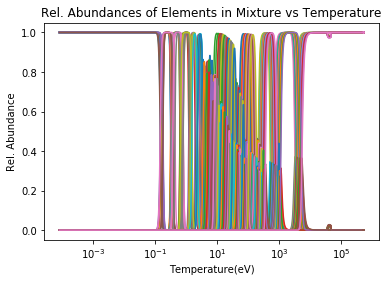

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


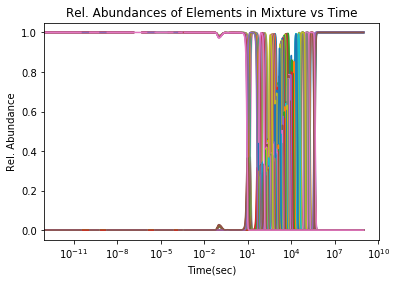

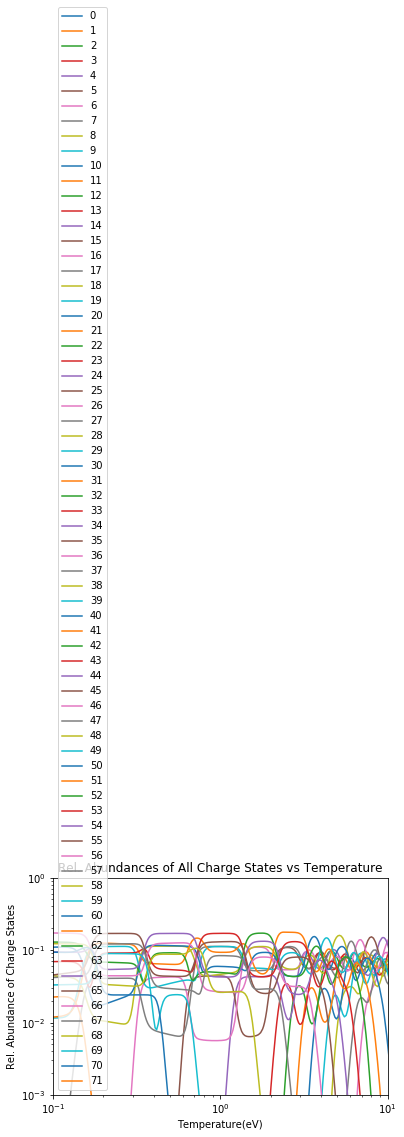

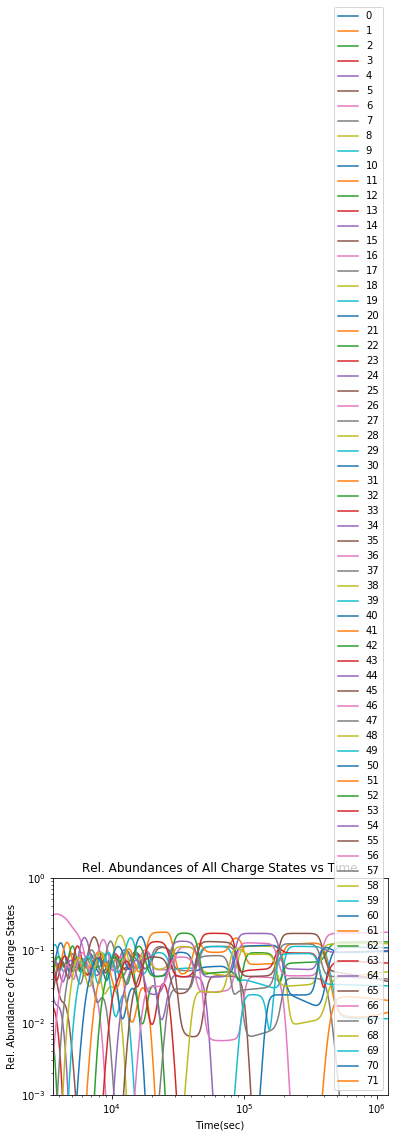

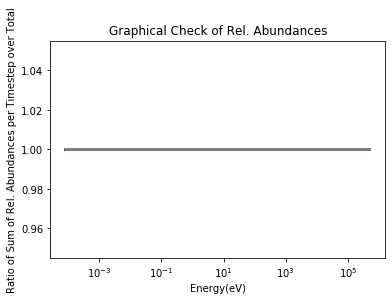

This calculation took 24.855559126999992  sec to graph


In [20]:
plotter(YI)


This is the graph for element  58 so there are  59  ionization states graphed


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


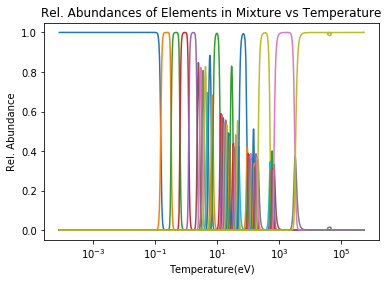

This is the graph for element  59 so there are  60  ionization states graphed


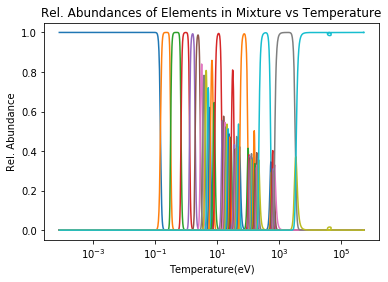

This is the graph for element  60 so there are  61  ionization states graphed


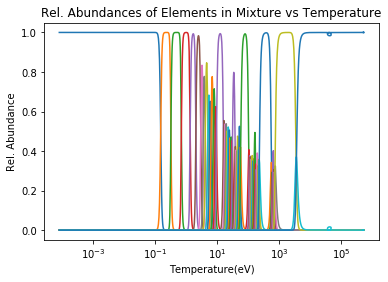

This is the graph for element  61 so there are  62  ionization states graphed


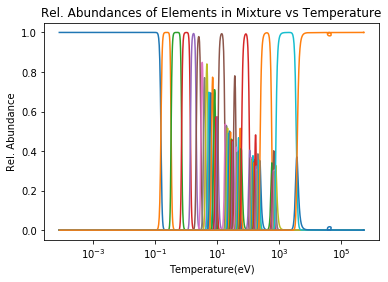

This is the graph for element  62 so there are  63  ionization states graphed


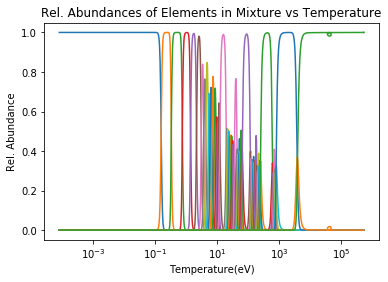

This is the graph for element  63 so there are  64  ionization states graphed


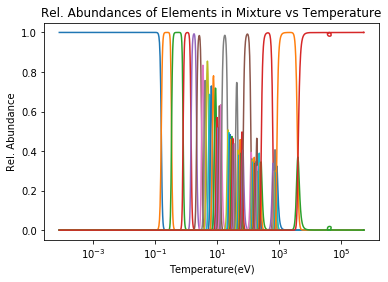

This is the graph for element  64 so there are  65  ionization states graphed


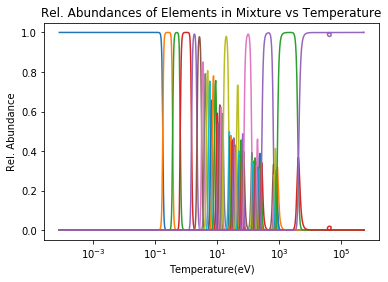

This is the graph for element  65 so there are  66  ionization states graphed


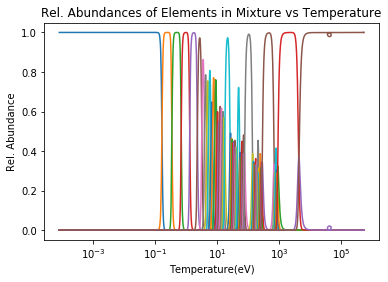

This is the graph for element  66 so there are  67  ionization states graphed


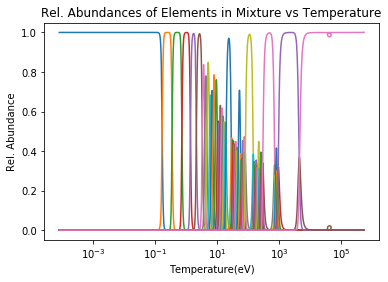

This is the graph for element  67 so there are  68  ionization states graphed


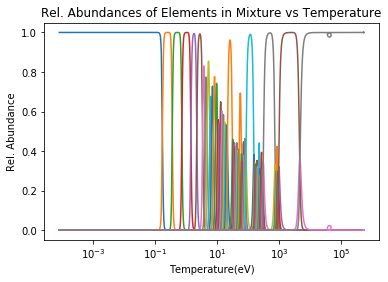

This is the graph for element  68 so there are  69  ionization states graphed


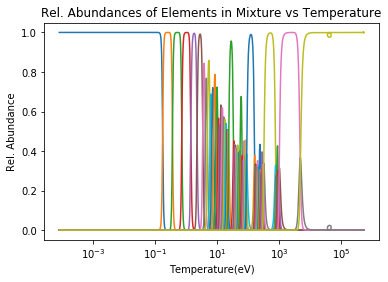

This is the graph for element  69 so there are  70  ionization states graphed


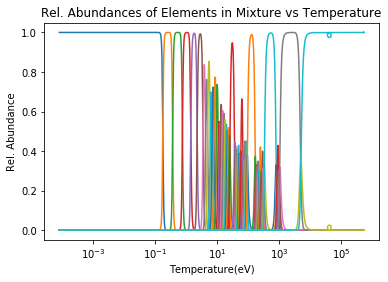

This is the graph for element  70 so there are  71  ionization states graphed


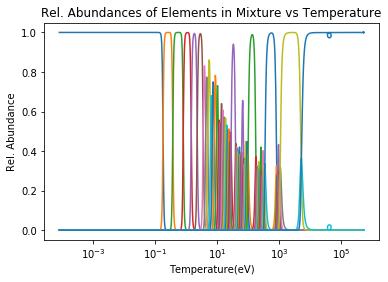

This is the graph for element  71 so there are  72  ionization states graphed


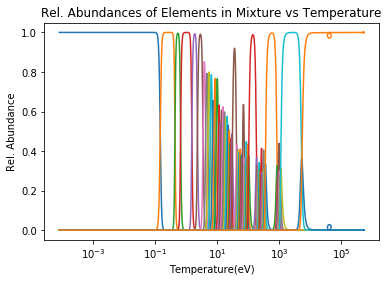

In [21]:
#Just plotting all the abundances seperately
element_num = 58 #Z of first lanthanide
for Y in YI:
    Ytot = np.sum(Y,1)
    print('This is the graph for element ',element_num,'so there are ',element_num+1,' ionization states graphed')
    for i in range(len(Y[0])):
        plt.semilogx(kbEvpGK*np.array(full_temp),(Y[:,i])/Ytot)
        plt.xlabel("Temperature(eV)")
        plt.ylabel("Rel. Abundance")
        plt.title("Rel. Abundances of Elements in Mixture vs Temperature")
    element_num+=1
    plt.show()
        

In [11]:
isotopic_abundances,potentials = initialization(np.arange(58,72,1))

In [22]:
for i in range(len(isotopic_abundances)):
    print('This is the abundance graph of element: ',(i+58))
    Ytot_isotopic = np.sum(isotopic_abundances[i])
    plt.semilogx(kbEvpGK*np.array(full_temp),isotopic_abundances[i]/Ytot_isotopic,label = (i+58))
    plt.legend()
    plt.xlabel("Temperature(eV)")
    plt.ylabel("Total Abundance of Each Lanthanide")
    plt.title("Abundances of All Elemental Abundances vs Temperature")
    plt.show()

NameError: name 'isotopic_abundances' is not defined